In [46]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import glob
import scipy.ndimage
import matplotlib.pyplot as plt
import ipyvolume

import scipy as sp
import pywt

import time, datetime


import SimpleITK as sitk
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/media/mike/tera/data/databowl/kgsamples/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

# Dicom coordinate system for dummies
![xplane](https://1.bp.blogspot.com/-3Z7kL7qKpJs/UbD9LNQNvSI/AAAAAAAAOSU/sXq82sHiCDM/s320/Patient-X.png)

![yplane](https://2.bp.blogspot.com/-VOL2o2GGEIE/UbD-_9e2e3I/AAAAAAAAOSk/WLPQ_Vm_Nsg/s320/Patient-Y.png)

![zplate](https://3.bp.blogspot.com/-lnlfTQiH1dc/UbD_yTPlO3I/AAAAAAAAOSw/T6RP6DF5RwE/s320/Patient-Z.png)

In [4]:
luna_path =  '/media/mike/tera/data/databowl/luna/'
luna_subset_path = '/media/mike/tera/data/databowl/luna/subset0/'
output_path = luna_path + 'output/'
file_list=glob.glob(luna_subset_path+"*.mhd")

#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_origin(filepath):
    itk_img = sitk.ReadImage(filepath)
    origin = np.array(itk_img.GetOrigin())
    return origin

def coord_to_ary_idx(coord, origin):
    coord = np.array(coord)
    origin = np.array(origin)
    x, y, z = coord - origin
    absidx = x, y, z # i have no idea why these things use such crazy indexing. but this will match the numpy slicing dims
    print(absidx)
    return list(map(int, absidx))

def get_fiducial_slice(coord, edgelen=48):
    ''' '''
    x, y, z = map(int, coord)
    m = edgelen // 2
    print(x+m, x-m, y+m, y-m, z+m, z-m)
    return (x-m, x+m, y-m, y+m, z-m, z+m)
    
def draw_fiducial_cube(ary_shape, coord, edgelen=48, dtype='int16'):
    
    ary = np.ones(ary_shape, dtype=dtype)
    x0, x1, y0, y1, z0, z1 = get_fiducial_slice(coord, edgelen=edgelen)
    ary[:z0] = 0
    ary[z1:] = 0
    ary[:,:y0] = 0
    ary[:,y1:] = 0
    ary[:,:,:x0] = 0
    ary[:,:,x1:] = 0
    print(np.sum(ary))
    return ary
 
def get_filename(case):
    global file_list # gross, yet effective...
    for f in file_list:
        if case in f:
            return(f)
        
def strip_uid(path):
    fname = os.path.basename(path)
    return fname.strip('.mhd.npy')
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

In [5]:
dfs = df_node.sort_values(by='diameter_mm', ascending=0)
dfs.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
1011,1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803...,60.775061,74.123970,-214.782347,25.233202,/media/mike/tera/data/databowl/luna/subset0/1....
1141,1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...,109.116637,48.589511,-120.892058,21.583112,/media/mike/tera/data/databowl/luna/subset0/1....
1084,1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840...,56.393154,67.680087,-64.674453,19.653877,/media/mike/tera/data/databowl/luna/subset0/1....
420,1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116...,-83.158083,-21.678997,-97.004376,18.783233,/media/mike/tera/data/databowl/luna/subset0/1....
336,1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205...,94.635117,-17.372059,-204.396127,17.753232,/media/mike/tera/data/databowl/luna/subset0/1....


In [6]:
print(len(df_node))
resamp_path = '/media/mike/tera/data/databowl/resampled_images/'
resamps = glob.glob(resamp_path + '*.mhd.npy')
print(len(resamps))

112
89


In [7]:
uids = [strip_uid(path) for path in resamps]
# sum([uid in uids for uid in dfs['seriesuid'].values]) # check if the data is there
# sum([dfs['seriesuid'].values[0] in path for path in resamps])

In [8]:
biggest = dfs.iloc[3]

In [9]:
def padcrop_vol(vol, newshape=[360, 360, 360]):
    vol2 = np.array(vol)
    shape = vol.shape
    z, y, x = shape
    mids = [d // 2 for d in shape]
    for dim in range(3):
        if shape[dim] < newshape[dim]:
            pad_amt = (newshape[dim] - shape[dim]) // 2
            parity = (shape[dim] & 1) ^ (newshape[dim] & 1)
            pad_tup = (pad_amt, pad_amt + parity) # 
            pad_list = [(0,0), (0,0), (0,0)]
            pad_list[dim] = pad_tup
            vol2 = np.pad(vol2, pad_list, mode='constant', constant_values=0)
        if shape[dim] > newshape[dim]:
            slc_amt = (shape[dim] - newshape[dim]) // 2
            parity = (shape[dim] & 1) ^ (newshape[dim] & 1)
            slc_tup = (slc_amt, shape[dim] - slc_amt - parity) # 
            null1, vol2, null2 = np.split(vol2, slc_tup, dim)

    return vol2

In [10]:
# mask = np.ones(pix_resampled.shape)
# mz, my, mx = pix_resampled.shape
# print(mz, my, mx)
# mask[140:] = 0
# mask[:110] = 0
# mask[:,:50] = 0
# mask[:,my-50:] = 0
# mask[:,:,mx-50:] = 0
# mask[:,:,:50] = 0
# mask2 = np.less(pix_resampled,1267)
# mask3 = np.greater(pix_resampled,400)

# ipyvolume.quickvolshow(pix_resampled*mask*mask3, width=1000, height=1000, level=[.26, .3, .85], level_width=[.5, .1, .05])

In [11]:
ary = np.load(resamp_path + biggest['seriesuid'] + '.mhd.npy')
print(ary.shape, np.amin(ary), np.amax(ary), np.mean(ary))

(332, 500, 500) -2488 3964 -873.924926819


In [59]:
%%timeit
ary2 = sp.ndimage.zoom(ary, (.25,.25,.25))
print(ary2.shape)

(83, 125, 125)
(83, 125, 125)
(83, 125, 125)
(83, 125, 125)
1 loop, best of 3: 2.4 s per loop


In [60]:
%%timeit

ary2 = pywt.dwtn(ary, 'haar')
ary3 = pywt.dwtn(ary2['aaa'], 'haar')
print(ary3['aaa'].shape)

(83, 125, 125)
(83, 125, 125)
(83, 125, 125)
(83, 125, 125)
1 loop, best of 3: 1.69 s per loop


In [57]:
# %%timeit -n1 -r1

start = datetime.datetime.now()

ary2 = pywt.dwtn(ary, 'haar')
# ary3 = pywt.dwtn(ary2['aaa'], 'haar')
# ipyvolume.quickvolshow(ary3['aaa'])
ipyvolume.quickvolshow(ary2['aaa'])


/home/mike/ve/ml/lib/python3.5/site-packages/ipyvolume/serialize.py:21: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [58]:
print('done, t={}'.format(datetime.datetime.now()- start))


done, t=0:00:04.491348


In [23]:
print(type(ary2))

<class 'numpy.ndarray'>


In [25]:
ary2.shape

(166, 250, 250)

In [29]:
aa = pywt.dwtn(ary, 'haar')
type(aa)

dict

In [10]:
biggest

seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116...
coordX                                                  -83.1581
coordY                                                   -21.679
coordZ                                                  -97.0044
diameter_mm                                              18.7832
file           /media/mike/tera/data/databowl/luna/subset0/1....
Name: 420, dtype: object

In [11]:
nx, ny, nz = biggest['coordX'], biggest['coordY'], biggest['coordZ']
nx, ny, nz

(-83.158082809999996, -21.678996940000001, -97.00437642)

In [12]:
origin = get_origin(luna_subset_path + biggest['seriesuid'] + '.mhd')
origin

array([-237.300003, -250.      , -349.5     ])

In [13]:
ary0 = ary - np.amin(ary) + 1

In [14]:
ary2 = ary * (ary < 4000)

In [15]:
mask = ary < -2000
mask = mask * 1800
ary2 = ary + mask
mask.shape, np.mean(mask)

((332, 500, 500), 426.12269638554216)

In [16]:
ary2.shape, np.mean(ary2)

((332, 500, 500), -447.80223043373496)

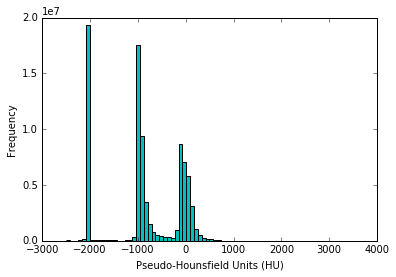

In [17]:
plt.hist(ary.flatten(), bins=80, color='c')
plt.xlabel("Pseudo-Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

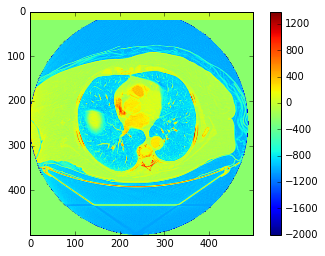

In [18]:
img = np.array(ary2[180])
img[:20] = 0 # [z0:z1, y1:y0, x1:x0]
plt.imshow(img)
plt.colorbar()

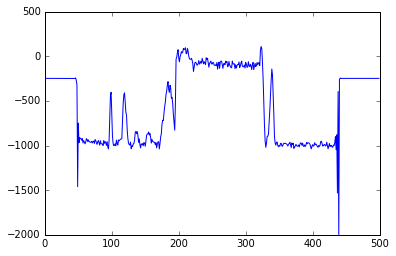

In [19]:
plt.plot(ary2[50][100])

In [20]:
absidx = coord_to_ary_idx((nx, ny, nz), origin)
absidx

(154.14192019000001, 228.32100306000001, 252.49562358)


[154, 228, 252]

In [21]:
fid = draw_fiducial_cube(ary.shape, (nx,ny,nz), 20)
nporig = draw_fiducial_cube(ary.shape, (25,25,25))
tumor = draw_fiducial_cube(ary.shape, absidx, 30)

-73 -93 -11 -31 -87 -107
8000
49 1 49 1 49 1
110592
169 139 243 213 267 237
27000


In [22]:
vol = np.array(ary0, dtype=np.int16) 
vol +=  5000*nporig + 5000*fid +5000*tumor
# vol = np.array(vol, dtype=np.int16)
print(type(vol))
print(vol.shape, vol.dtype)

<class 'numpy.ndarray'>
(332, 500, 500) int16


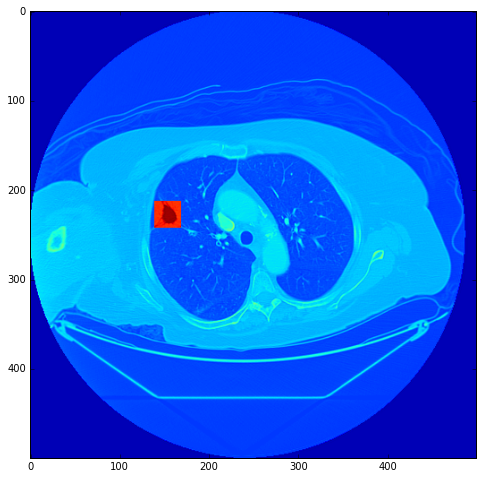

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(vol[absidx[2]])

In [24]:
from ipyvolume import 

SyntaxError: invalid syntax (<ipython-input-24-18d56e6f4bca>, line 1)

In [ ]:
12*32

In [ ]:
128*1e6 / (500)**2

In [ ]:
2**26 / 1e6

In [ ]:
262*500*500*2

In [25]:
vv = -vol[80:]
print(vv.shape, np.prod(vv.shape), np.prod(vv.shape)*2/1e6)
ipyvolume.quickvolshow(vv, width=1000, height=1000, level=[.12, .41, .57], opacity=[.01, .02, .01], level_width=[.05, .1, .05])
# fig = ipyvolume.pylab.figure()
# fig.camera_control = 'trackball'

(252, 500, 500) 63000000 126.0


/home/mike/ve/ml/lib/python3.5/site-packages/ipyvolume/serialize.py:21: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)
Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
ary[50][0][0]

In [ ]:
assert 0

In [ ]:
ipyvolume.quickvolshow(ary, width=1000, height=1000, level=[.12, .41, .57], opacity=[.01, .02, .01], level_width=[.5, .1, .05])

In [ ]:
mask = np.ones(ary.shape)
mask[180:] = 0
ipyvolume.quickvolshow(ary0*mask, width=1000, height=1000, level=[.12, .41, .57], opacity=[.01, .02, .01], level_width=[.5, .1, .05])

In [ ]:
np.amin(ary), np.amax(ary)

In [ ]:
vv = np.ones((400,500,500), dtype='int16')
ipyvolume.quickvolshow(vv)